# Обучение модели классификации ношения СИЗ на людях

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from pprint import pformat

from pydantic import BaseModel, Field
from detectron2.utils.logger import setup_logger
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.engine.hooks import BestCheckpointer
import datumaro as dm

from ppe_modelling.utils import system_info_banner, current_run_tag
from ppe_modelling.logger import logger
from ppe_modelling.detectron_utils import visualize_ds, infer_ds
from ppe_modelling.detectron_cfg import get_infer_cfg, configure_classification_cfg
from ppe_modelling.detectron_utils import unregister_if_exists

detectron_logger = setup_logger()

## System info

In [3]:
logger.info(system_info_banner())

[ppe-modelling] 10.04.2025 01:23:35 === System Information ===
System: Linux
Machine: x86_64
OS Version: #59~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Mar 19 17:07:41 UTC 2
OS Name: Linux-6.8.0-57-generic-x86_64-with-glibc2.35

=== Hardware Information ===
RAM: 62.64 GB
CPU: x86_64 (20 cores)
GPU: NVIDIA GeForce RTX 3090
nvcc: nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0

=== Libraries Information ===
torch: 2.6; cuda: cu124
detectron2: 0.6


## Settings

In [7]:
class PPETrainSettings(BaseModel):
    datumaro_ds_dir: Path = Path('../data/ppe_classification_dataset')
    ppe_classes: list[str] = ['Safety Vest', 'Hardhat']
    output_dir: Path = Path('../logs/')
    run_tag: str = Field(default_factory=lambda x: current_run_tag()+"_ppe_classification")

settings = PPETrainSettings()

logger.info("\n" + pformat(settings.model_dump()))

[ppe-modelling] 10.04.2025 01:38:10 
{'datumaro_ds_dir': PosixPath('../data/ppe_classification_dataset'),
 'output_dir': PosixPath('../logs'),
 'ppe_classes': ['Safety Vest', 'Hardhat'],
 'run_tag': '10apr-01_38_10_ppe_classification'}


## Register Datasets

In [23]:


TRAIN_DS_DETECTRON_TAG = 'ds_train_ppe_classification'
VAL_DS_DETECTRON_TAG = 'ds_val_ppe_classification'
TEST_DS_DETECTRON_TAG = 'ds_test_ppe_classification'
PPE_DATUMARO_PATH = settings.datumaro_ds_dir
CLASSES = settings.ppe_classes

def read_datumaro_ds(ds_path: str, subset: str, target_attributes: list[str]) -> list[str]:
    ds_dicts = []
    ds = dm.Dataset.import_from(ds_path, 'datumaro')
    for item in ds:
        if item.subset != subset:
            continue
        height,width = item.media.size #h,w
        attributes = item.annotations[0].attributes
        target = {k:v for k, v in attributes.items() if k in target_attributes}
        result_dict = {
            "file_name": item.media.path,
            "height": height,
            "width": width,
            "image_id": item.id,
            "target": target
        }
        ds_dicts.append(result_dict)
    detectron_logger.info(f"Loaded {len(ds_dicts)} samples from Datumaro '{subset}' split at {ds_path}")
    return ds_dicts


def register_datumaro_classification(ds_path: str, subset: str, ds_tag: str, attributes_fields: list[str]):
    unregister_if_exists(ds_tag)
    ds_func = lambda: read_datumaro_ds(ds_path, subset, attributes_fields)  # noqa: E731
    DatasetCatalog.register(ds_tag, ds_func)
    MetadataCatalog.get(ds_tag).attributes_fields = attributes_fields

register_datumaro_classification(PPE_DATUMARO_PATH, 'train', TRAIN_DS_DETECTRON_TAG, attributes_fields=settings.ppe_classes)
register_datumaro_classification(PPE_DATUMARO_PATH, 'val', VAL_DS_DETECTRON_TAG, attributes_fields=settings.ppe_classes)
register_datumaro_classification(PPE_DATUMARO_PATH, 'test', TEST_DS_DETECTRON_TAG, attributes_fields=settings.ppe_classes)

In [24]:
ds_train = DatasetCatalog.get(TRAIN_DS_DETECTRON_TAG)
ds_train_meta = MetadataCatalog.get(TRAIN_DS_DETECTRON_TAG)

ds_val = DatasetCatalog.get(VAL_DS_DETECTRON_TAG)
ds_val_meta = MetadataCatalog.get(VAL_DS_DETECTRON_TAG)

ds_test = DatasetCatalog.get(TEST_DS_DETECTRON_TAG)
ds_test_meta = MetadataCatalog.get(TEST_DS_DETECTRON_TAG)

[04/10 01:58:32 detectron2]: Loaded 7873 samples from Datumaro 'train' split at ../data/ppe_classification_dataset
[04/10 01:58:33 detectron2]: Loaded 127 samples from Datumaro 'val' split at ../data/ppe_classification_dataset
[04/10 01:58:34 detectron2]: Loaded 135 samples from Datumaro 'test' split at ../data/ppe_classification_dataset


## Visualize data

### Train

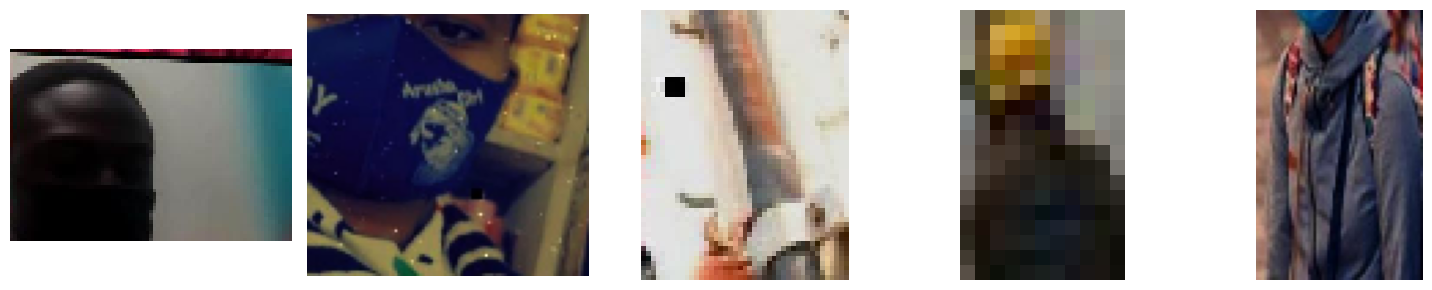

In [25]:
_ = visualize_ds(ds_train, ds_train_meta, n=5, cols=5)

### Val

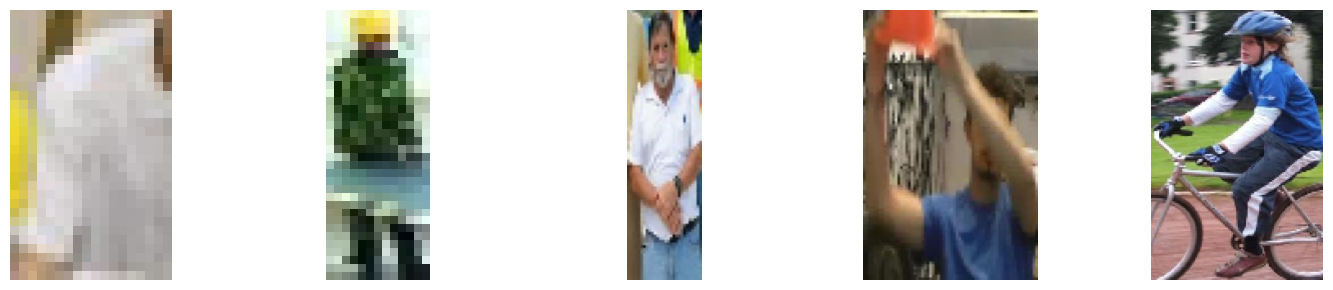

In [26]:
_ = visualize_ds(ds_val, ds_val_meta, n=5, cols=5)

### Test

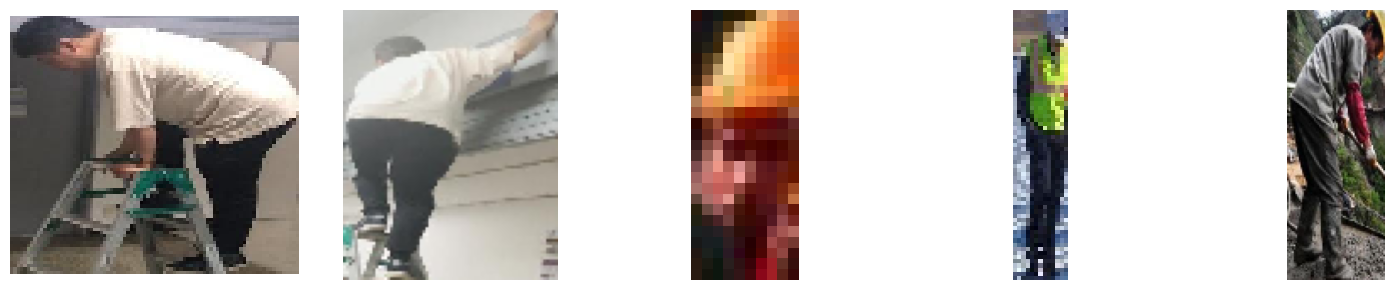

In [27]:
_ = visualize_ds(ds_test, ds_test_meta, n=5, cols=5)


## Train

### Define configuration

In [31]:
def get_train_cfg(output_dir):
    return configure_classification_cfg(
        len(CLASSES),
        [TRAIN_DS_DETECTRON_TAG],
        [TEST_DS_DETECTRON_TAG, VAL_DS_DETECTRON_TAG],
        output_dir=output_dir,
        epochs=20,
        eval_period_epochs=1,
        solver_steps=[5_000, 10_000],
    )

output_dir = settings.output_dir / 'ppe_classification_train' / settings.run_tag
# output_dir = "../logs/ppe_train/09apr-23_30_51_person_detection"
# output_dir = train_settings.output_dir / 'ppe_train' / '06apr-17_24_43'
logger.info(output_dir)
cfg = get_train_cfg(output_dir)
logger.info(cfg)

[ppe-modelling] 10.04.2025 02:15:31 ../logs/ppe_classification_train/10apr-01_38_10_ppe_classification


[04/10 02:15:32 detectron2]: Loaded 7873 samples from Datumaro 'train' split at ../data/ppe_classification_dataset


[ppe-modelling] 10.04.2025 02:15:32 CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ['ds_test_ppe_classification', 'ds_val_ppe_classification']
  TRAIN: ['ds_train_ppe_classification']
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (800,)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32, 64, 128, 256, 512]]
  BACKBONE:
    FREEZE_AT: 2
    NAM

### Define trainer

In [ ]:
# self.trainer.storage.latest() - gives latest metrics...
# class TrainerBase:
#     def __init__(self) -> None:
#         self.storage: EventStorage
# However, no calls are being made that can be of mask-rcnn. That comes from model?

class ClassificationTrainer(DefaultTrainer):
    # @classmethod
    # def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    #     # if output_folder is None:
    #         # output_folder = os.path.join(cfg.OUTPUT_DIR, "coco_evaluator_val")
    #     return COCOEvaluator(dataset_name, cfg, True, output_folder)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_eval_loader(cfg)
    
    @classmethod
    def build_eval_loader(cls, cfg):
        return build_detection_train_loader(cfg)

    @classmethod
    def build_model(cls, cfg):
        """
        Returns:
            torch.nn.Module:
        """
        # model = build_model(cfg)


        logger = detectron_logger
        logger.info("Model:\n{}".format(model))
        return model


    def build_hooks(self):
        hooks = super().build_hooks()
        best_checkpoint_hook = BestCheckpointer(
            self.cfg.TEST.EVAL_PERIOD,
            checkpointer=self.checkpointer,
            val_metric="auc"
        )
        new_hooks = [best_checkpoint_hook]
        new_hooks = []
        hooks.extend(new_hooks)
        return hooks

trainer = ClassificationTrainer(cfg)
trainer.resume_or_load()

[04/10 01:18:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

### Run Train

In [ ]:
results = trainer.train()
logger.info("\n" + pformat(results))

[04/10 01:18:59 d2.engine.train_loop]: Starting training from iteration 8907
[04/10 01:19:05 d2.utils.events]:  eta: 1:07:02  iter: 8919  total_loss: 0.3808  loss_cls: 0.1163  loss_box_reg: 0.224  loss_rpn_cls: 0.01404  loss_rpn_loc: 0.03436    time: 0.5122  last_time: 0.5411  data_time: 0.0994  last_data_time: 0.1081   lr: 0.0001  max_mem: 5163M
[04/10 01:19:16 d2.utils.events]:  eta: 1:06:52  iter: 8939  total_loss: 0.4121  loss_cls: 0.1164  loss_box_reg: 0.2401  loss_rpn_cls: 0.01255  loss_rpn_loc: 0.02795    time: 0.5124  last_time: 0.4617  data_time: 0.0898  last_data_time: 0.0756   lr: 0.0001  max_mem: 5164M
[04/10 01:19:26 d2.utils.events]:  eta: 1:06:08  iter: 8959  total_loss: 0.3929  loss_cls: 0.1099  loss_box_reg: 0.2297  loss_rpn_cls: 0.01397  loss_rpn_loc: 0.02844    time: 0.5064  last_time: 0.4925  data_time: 0.0880  last_data_time: 0.0853   lr: 0.0001  max_mem: 5164M
[04/10 01:19:36 d2.utils.events]:  eta: 1:06:06  iter: 8979  total_loss: 0.3408  loss_cls: 0.09158  loss_

In [ ]:
trainer.storage.latest()

{'rpn/num_pos_anchors': (18.5, 8906),
 'rpn/num_neg_anchors': (237.5, 8906),
 'roi_head/num_fg_samples': (47.0, 8906),
 'roi_head/num_bg_samples': (209.0, 8906),
 'fast_rcnn/cls_accuracy': (0.94189453125, 8906),
 'fast_rcnn/fg_cls_accuracy': (0.8111702127659575, 8906),
 'fast_rcnn/false_negative': (0.18882978723404256, 8906),
 'rank_data_time': (0.09682656000222778, 8906),
 'data_time': (0.09682656000222778, 8906),
 'total_loss': (0.4678731057792902, 8906),
 'loss_cls': (0.155992329120636, 8906),
 'loss_box_reg': (0.2713884115219116, 8906),
 'loss_rpn_cls': (0.01946341246366501, 8906),
 'loss_rpn_loc': (0.021028952673077583, 8906),
 'lr': (0.0001, 8906),
 'time': (0.48149019999982556, 8906),
 'eta_seconds': (0.0, 8906),
 'ds_test_person_detection/bbox/AP': (46.541296389245446, 8907),
 'ds_test_person_detection/bbox/AP50': (74.03420196018338, 8907),
 'ds_test_person_detection/bbox/AP75': (50.69380703171487, 8907),
 'ds_test_person_detection/bbox/APs': (26.68871244538663, 8907),
 'ds_tes

## Eval model

### Define predictor

In [14]:
print(len(CLASSES))

1


In [ ]:
output_dir = settings.output_dir / 'ppe_train' / '06apr-17_24_43'
model_file = "model_0004224.pth"
model_path = output_dir / model_file
config_file = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

cfg = get_infer_cfg(str(model_path), config_file, len(CLASSES))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[04/10 01:08:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../logs/ppe_train/06apr-17_24_43/model_0004224.pth ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (11, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (11,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (40, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (40,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weig

### Infer Train

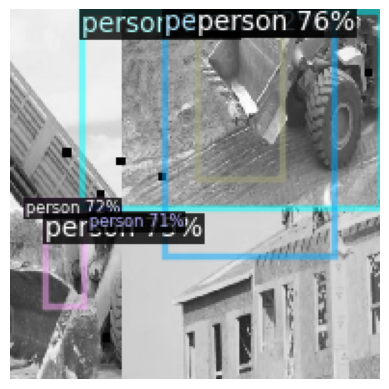

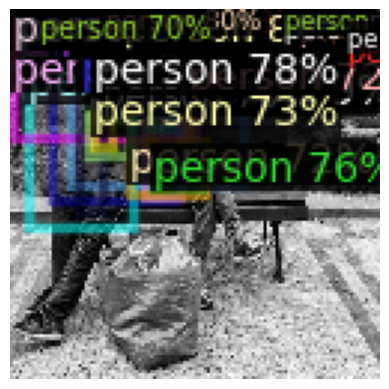

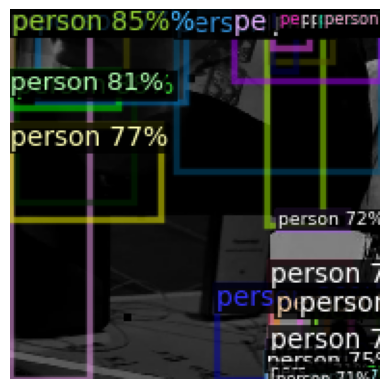

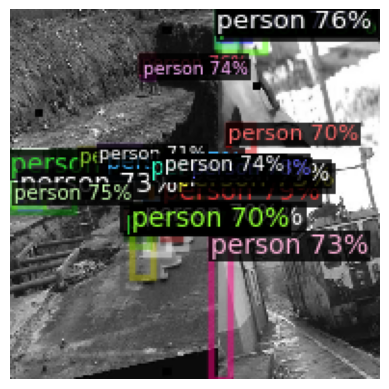

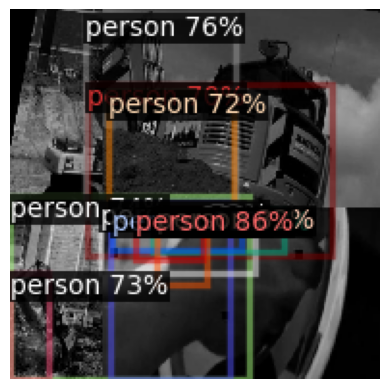

In [16]:
train_samples, train_predictions = infer_ds(predictor, ds_train, ds_train_meta, n=5)

### Infer Test

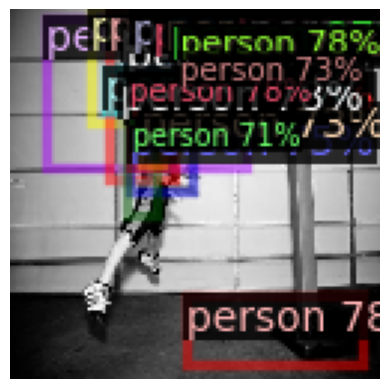

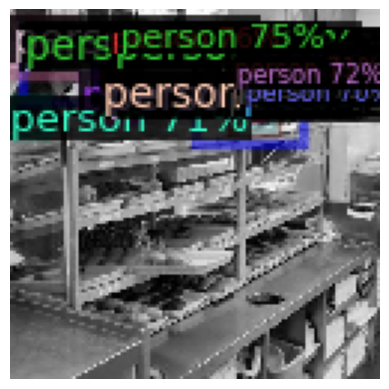

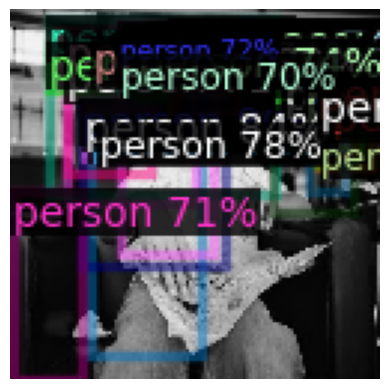

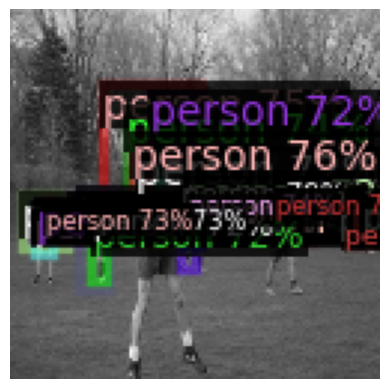

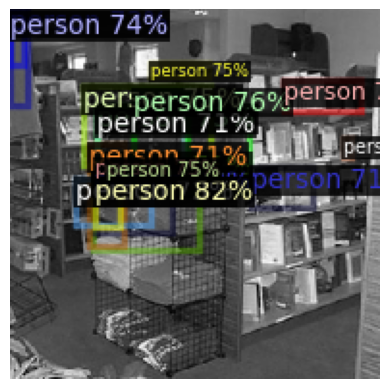

In [17]:
test_samples, test_predictions = infer_ds(predictor, ds_test, ds_test_meta, n=5)